# Historical Sea Ice
Welcome to the **Historical Sea Ice** notebook! In this notebook, we will provide a more complex example of how to use accessvis. 

In this notebook we will plot both the historical sea ice cover.
* Use custom shaders to display sea ice
* Animate the sea ice every day for one year.
* Calculate the size of sea ice each year.
  * This includes calculating the area of each grid cell.
* Finding the day of the year where the sea ice extent is largest.
* Animating the seaice over time.

The data used is available in project xp65 on gadi and takes about 5 minutes to run.

In [1]:
import datetime
import glob
import os
import subprocess

import numpy as np
import matplotlib.pyplot as plt
import pytz
import scipy
from tqdm.notebook import tqdm
import xarray as xr

import accessvis

In [2]:
hemisphere = 'south'
#hemisphere = 'north'

accessvis.resolution_selection(default=3)

Low-res 2K - fast for testing
Mid-res 4K - good enough for full earth views
High res 8K - better if showing close up at country scale
Ultra-high 16K - max detail but requires a fast GPU with high memory


Dropdown(description='Detail:', index=2, options=(('Low-res 2K', 1), ('Mid-res 4K', 2), ('High-res 8K', 3), ('…

## Download Data
On gadi, this data is available on xp65.
If you are not using gadi, please change base_dir below and it will download the relevant files.

NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4
* https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf
* https://nsidc.org/data/g02202/versions/4
* https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/2023/
* https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/ ??

#### Historical Data

In [3]:
base_dir = '/g/data/xp65/public/apps/access-vis-data/'

#https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/2023/
H = hemisphere[0].lower() + 'h'

#All years data
fn = f'seaice_conc_daily_{H}_*.nc'
# Cached data location
datadir = f'{base_dir}noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/'
print(datadir)

#download files if not existing
cmd = f"wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G02202_V4/{hemisphere}/aggregate/"
p = subprocess.Popen(cmd.split(), cwd=base_dir)
p.wait()

/g/data/xp65/public/apps/access-vis-data/noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/


File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/index.html’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1978_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1979_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1980_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1981_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1982_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1983_v04r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G02202_V4/south/aggregate/seaice_conc_daily_sh_1984_v04r00.nc’ already there; no

0

#### Near Real Time Data
Note that on Gadi, you may not have write permissions and will not be able to update.

In [4]:
#https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/

#Get/update all daily NRT data for current year
subdir = f'noaadata.apps.nsidc.org/NOAA/G10016_V2/{hemisphere}/daily/'
year = datetime.datetime.now().year

# To get the latest data, you will need to delete index.html first, and then re-run.
ifn = os.path.join(base_dir, subdir, str(year), 'index.html')
if os.path.exists(ifn):
    os.remove(ifn)

cmd = f"wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G10016_V2/{hemisphere}/daily/{year}/"
print(cmd)
p = subprocess.Popen(cmd.split(), cwd=base_dir)
p.wait()

wget -nc -e robots=off --recursive --no-parent https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/


--2024-12-16 15:34:09--  https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/
Resolving noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)... 128.138.135.43
Connecting to noaadata.apps.nsidc.org (noaadata.apps.nsidc.org)|128.138.135.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/index.html’

     0K .......... .......... .......... .......                178K=0.2s

2024-12-16 15:34:10 (178 KB/s) - ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/index.html’ saved [38908]

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_20240401_f18_v02r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_20240402_f18_v02r00.nc’ already there; not retrieving.

File ‘noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2024/seaice_conc_daily_icdr_sh_202404

0

## Open Data:

In [5]:
ds_sea_ice = xr.open_mfdataset(datadir + fn, combine='nested', concat_dim='tdim')
ds_sea_ice

<xarray.Dataset> Size: 62GB
Dimensions:                      (tdim: 16320, y: 332, x: 316)
Coordinates:
    time                         (tdim) datetime64[ns] 131kB dask.array<chunksize=(68,), meta=np.ndarray>
    xgrid                        (x) float32 1kB dask.array<chunksize=(316,), meta=np.ndarray>
    ygrid                        (y) float32 1kB dask.array<chunksize=(332,), meta=np.ndarray>
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc              (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_bt_seaice_conc         (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    nsidc_nt_seaice_conc         (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    projection                   (tdim) |S1 16kB b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc        (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    spatial_interpolation_flag   (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    stdev_of_cdr_seaice_conc     (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    temporal_interpolation_flag  (tdim, y, x) float32 7GB dask.array<chunksize=(1, 332, 316), meta=np.ndarray>
    latitude                     (tdim, y, x) float32 7GB dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
    longitude                    (tdim, y, x) float32 7GB dask.array<chunksize=(68, 332, 316), meta=np.ndarray>
Attributes: (12/39)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc
    ...                        ...
    acknowledgment:            This project was supported in part by a grant ...
    platform:                  NIMBUS-7
    sensor:                    SMMR > Scanning Multichannel Microwave Radiometer
    date_created:              2021-06-21T21:22:35Z
    time_coverage_start:       1978-10-25T00:00:00Z
    time_coverage_end:         1978-12-31T23:59:59Z

In [6]:
lyear = datetime.datetime.now().year - 1 #Last year

#Note: The first 6 months are in an aggregate file, the rest in daily files
aggregate = [f'{datadir}seaice_conc_daily_{H}_{lyear}_v04r00.nc']
dailyfiles_24 = sorted(glob.glob(os.path.join(base_dir, subdir, str(year),f'seaice_conc_daily_icdr_{H}_2024*_f18_v02r00.nc')))
files = aggregate + dailyfiles_24

ds_sea_ice_NRT = xr.open_mfdataset(files, combine='nested', concat_dim='tdim')

Data information:

In [7]:
STEPS = ds_sea_ice_NRT['cdr_seaice_conc'].shape[0]
print('Number of time stpes:', STEPS)

latitude = np.array(ds_sea_ice['latitude'].sel(tdim=0))
longitude = np.array(ds_sea_ice['longitude'].sel(tdim=0))
print('Lat/Lon Extents:')
print(latitude[0][0], longitude[0][0])
print(latitude[-1][-1], longitude[-1][-1])

dates = np.array(ds_sea_ice['time']).astype('datetime64[D]')
dates_NRT = np.array(ds_sea_ice_NRT['time']).astype('datetime64[D]')
print('Start/End Dates: ', min(dates), max(dates))
print('Start/End NRT Dates', min(dates_NRT), max(dates_NRT))

Number of time stpes: 525
Lat/Lon Extents:
-39.36487 -42.23257
-41.58345 135.0
Start/End Dates:  1978-10-25 2023-06-30
Start/End NRT Dates 2023-01-01 2024-12-13


In [8]:
def get_data_at(date):
    #Find timestep index and dataset for given date
    if date.year >= 2023:
        if date > dates_NRT[-1]:
            return None
        #2023 (using data up to day 309 - 5/11/2023)
        #T = date.timetuple().tm_yday - 1 #Day of year [0-365]
        #ts = dates_NRT[T]
        itemindex = np.where(dates_NRT == date)
        T = itemindex[0]
        ts = dates_NRT[T]
        assert(ts == date)
        dat = ds_sea_ice_NRT.sel(tdim=T)
    else:
        itemindex = np.where(dates == date)
        T = itemindex[0]
        ts = dates[T] #.item() #.astype(datetime.datetime)
        assert(ts == date)
        dat = ds_sea_ice.sel(tdim=T)
    return dat

def get_grid():
    #Just get the raw grid points
    altitudes = np.zeros_like(latitude) + 0.0005 #Raise the sea ice slightly above sea level (0.001 = 1 Metre)
    arrays = accessvis.latlon_to_3D(latitude, longitude, altitudes)
    V = np.dstack(arrays)
    print(V.shape)
    return V

def get_ice_data_at(date):
    dat = get_data_at(date)
    if dat is None:
        return dat
    dat = dat['cdr_seaice_conc']
    #m = dat.where(dat>1)
    #mask = np.array(m) > 1
    dat = dat.where(dat>0)
    #dat = dat.where(dat<=1) #Clears mask
    data = np.array(dat)[0]
    #print(data.shape)
    
    #Land mask > 1.0
    #data[mask] = data.max() #Land mask - replace with max ice value

    if hemisphere == 'south':
        #Want to keep land max = 1.0 for antarctica, but clear islands
        #Clear tierra del fuego and nearby islands
        data[0:140,0:20] = 0.
    
        #Replace land with max ice
        data[data > 1.0] = 1.0
    else:
        #Replace land with max ice
        data[data > 1.0] = 0.0
    
    #Replace NaN with 0.0
    data[np.isnan(data)] = 0.0

    return data
   
def get_ice_data_at_orig(date):
    dat = get_data_at(date)
    dat = dat['cdr_seaice_conc'].where(dat['cdr_seaice_conc']<=1)
    dat = dat.where(dat>0)
    data = np.array(dat)
    data[np.isnan(data)] = 0.0
    return data[0]



def get_ice_image(D, mmin=None, mmax=None):
    #Normalise
    if mmin is not None and mmax is not None:
        image = (D-mmin)/(mmax-mmin)
        #Clip out of [0,1] range - in case defined range is not the global minima/maxima
        image = np.clip(image, 0, 1)
    else:
        image = D
    #Filter out < 0.1
    #image =  image * 0.91 #[image < 0.9] = 0.0
    #image[image < 0.1] = 0.0
    
    return np.uint8(image*255)

## Plotting a sample of the data

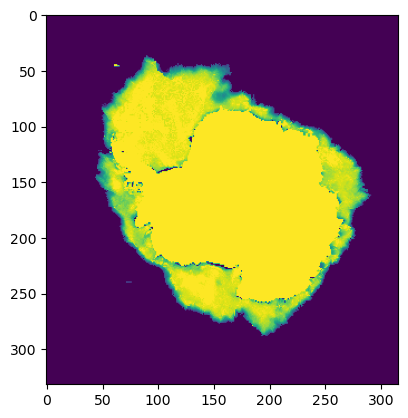

In [9]:
example_date = datetime.datetime.strptime("1980-06-01 00:00:00", "%Y-%m-%d %H:%M:%S")
example_data = get_ice_data_at(example_date.date())
example_image = get_ice_image(example_data)
plt.imshow(example_image)


## Plotting


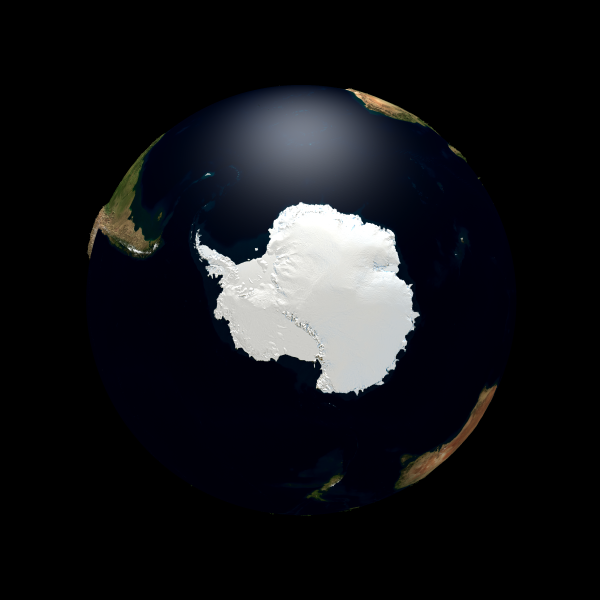

In [10]:
lv = accessvis.plot_earth(texture='bluemarble', waves=True, background='black', vertical_exaggeration=30, hemisphere=hemisphere[0].upper())
lv.set_properties(diffuse=0.6, ambient=0.85, specular=0.25, shininess=0.03, light=[1,1,0.98,1], lightpos=[0,0,10000,1])
lv.display(resolution=(600,600))

#### Ice rendering tweaks - sea ice render with textures

In [11]:
tris0 = lv.surface("sea_ice", renderer='sortedtriangles', ambient=0.9)
tris0['shaders'] = ['triShader_ice.vert', 'triShader_ice.frag']
uniforms = {}
for i in range(10,101,10):
    t = f"ice{i}"
    uniforms[t] = t + '.png'
tris0['uniforms'] = uniforms
tris0['repeat'] = True

z = 2
mesh = get_grid()
mesh = scipy.ndimage.zoom(mesh, [z,z,1], order=3)

tris0.vertices(mesh)

(332, 316, 3)


Example Plot (I'm plotting twice here as the shaders don't update immediately)

In [12]:
date = datetime.date(2001, 1, 1)
D = get_ice_data_at(date)
I = get_ice_image(D)
tris0.texture(I, flip=False)


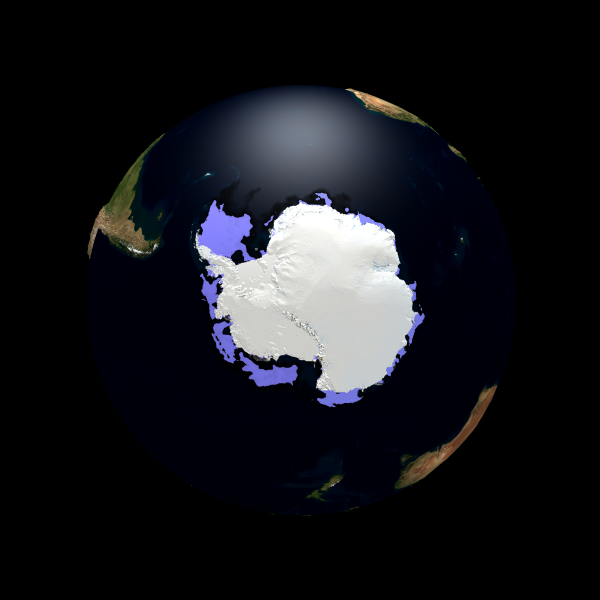


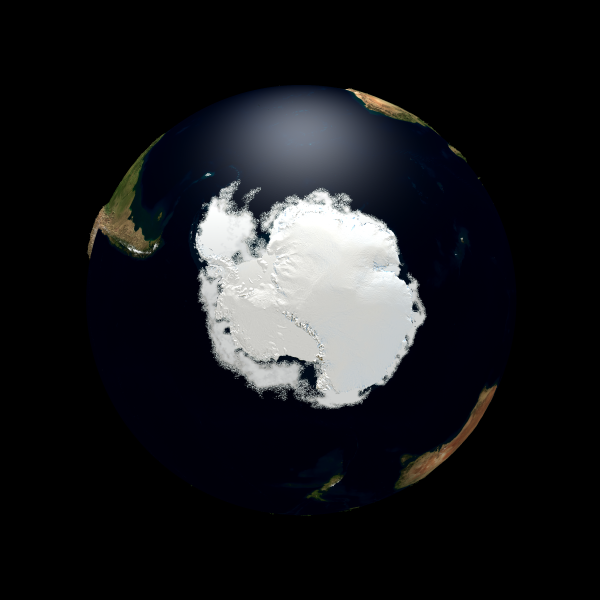

In [13]:
lv.display(resolution=(600,600))
lv.display(resolution=(600,600))

### Animation 2001:

#### Add widget

Output #0, mp4, to 'sea_ice_south.mp4':
  Stream #0:0: Unknown: none


  0%|          | 0/3 [00:00<?, ?it/s]

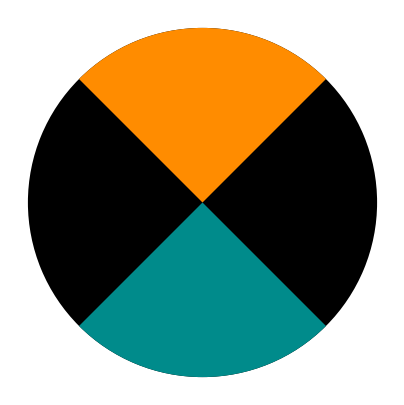

In [15]:
start = datetime.date(2001, 1, 1)
wid = accessvis.SeasonWidget(lv=lv, scale=0.2, offset=(1,0), text_colour='white')
#todo: change to 240fps, change year range too
with lv.video(filename=f'sea_ice_{hemisphere}.mp4', fps=30, resolution=(250,250), params="autoplay"):
    tz=pytz.timezone("Australia/Brisbane")

    for i in tqdm(range(365)):
        date = start + datetime.timedelta(days=i)
        D = get_ice_data_at(date)
        I = get_ice_image(D)
        wid.add_widget(date=date)

        tris0.texture(I, flip=False)

        
        # #Update sun position
        if hemisphere == 'north':
            #Brisbane time = UTC+10, so 22:00 == UTC midday
            when = datetime.datetime(date.year, date.month, date.day, 22, 0, 0, 0, tz)
        else:
            # Brisbane tz because no daylight savings
            when = datetime.datetime(date.year, date.month, date.day, 12, 0, 0, 0, tz)
        lv.set_properties(lightpos=accessvis.sun_light(time=when))
        accessvis.update_earth_datetime(lv, when=when, sunlight=True)
        
        lv.render()
wid.remove()# removing widget so we don't make loads of them if this gets run again.

## Data sources:

National Snow and Ice Data Center

- https://noaadata.apps.nsidc.org/
- https://nsidc.org/data/user-resources/help-center/how-access-and-download-noaansidc-data
- https://nsidc.org/about/data-use-and-copyright

Historical Antarctic daily satellite data
( NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 )
Data set id: G02202
DOI: 10.7265/efmz-2t65
- https://noaadata.apps.nsidc.org/NOAA/G02202_V4/south/daily/1978/ (-2023)
- https://nsidc.org/data/g02202/versions/4

    Meier, W. N., F. Fetterer, A. K. Windnagel, and J. S. Stewart. (2021). NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 4 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/efmz-2t65. Date Accessed 02-19-2024.

Current year Antarctic daily satellite data
( Near-Real-Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2 )
Data set id: G10016
DOI: 10.7265/tgam-yv28
- https://noaadata.apps.nsidc.org/NOAA/G10016_V2/south/daily/2023/
- https://nsidc.org/data/g10016/versions/2

    Meier, W. N., F. Fetterer, A. K. Windnagel, and J. S. Stewart. (2021). Near-Real-Time NOAA/NSIDC Climate Data Record of Passive Microwave Sea Ice Concentration, Version 2 [Data Set]. Boulder, Colorado USA. National Snow and Ice Data Center. https://doi.org/10.7265/tgam-yv28. Date Accessed 02-19-2024.

#### Earth satellite imagery and ocean/water masks
- https://earthobservatory.nasa.gov/features/BlueMarble

#### Topography:
- https://visibleearth.nasa.gov/images/73934/topography
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73934/gebco_08_rev_elev_21600x10800.png

#### Bathymetry
- https://visibleearth.nasa.gov/images/73963/bathymetry
- https://eoimages.gsfc.nasa.gov/images/imagerecords/73000/73963/gebco_08_rev_bath_21600x10800.png

#### Textures and misc resources
https://www.manytextures.com/texture/23/sea-water/ Sea water by ManyTextures.com is licensed under a Creative Commons Attribution 4.0 International License. https://creativecommons.org/licenses/by/4.0/